✅ Final Accuracy (Threshold=0.4): 0.613
Classification Report:
               precision    recall  f1-score   support

           0      0.701     0.637     0.668       400
           1      0.503     0.574     0.536       256

    accuracy                          0.613       656
   macro avg      0.602     0.606     0.602       656
weighted avg      0.624     0.613     0.616       656

Confusion Matrix:
 [[255 145]
 [109 147]]


<Figure size 1000x600 with 0 Axes>

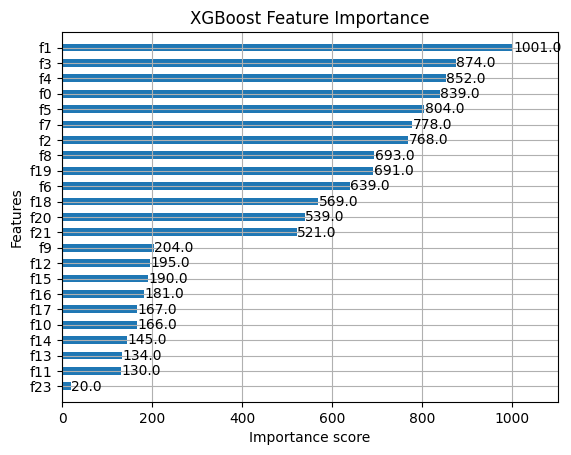

✅ Model + preprocessing saved successfully!
🔮 Prediction: {'potability': 0, 'probability': np.float32(0.21176898)}


In [2]:
# =========================================
# Water Potability Prediction - Clean Pipeline
# =========================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import xgboost as xgb

# ------------------------------
# 1. Load Data
# ------------------------------
df = pd.read_csv("water_potability.csv", encoding="latin-1")

# ------------------------------
# 2. WHO Standards (for WQI + features)
# ------------------------------
WHO_LIMITS = {
    "ph": 7.0,
    "Hardness": 300,
    "Solids": 500,
    "Chloramines": 4,
    "Sulfate": 250,
    "Conductivity": 400,
    "Organic_carbon": 10,
    "Trihalomethanes": 80,
    "Turbidity": 5
}

# ------------------------------
# 3. Feature Engineering
# ------------------------------
def calc_qi(observed, standard):
    return (observed / standard) * 100 if standard != 0 else 0

def engineer_features(df):
    df_new = df.copy()

    # QI features
    for col, limit in WHO_LIMITS.items():
        df_new[f"qi_{col}"] = df_new[col].apply(lambda x: calc_qi(x, limit) if pd.notnull(x) else np.nan)

    # Derived features
    df_new["pH_deviation"] = df_new["ph"].apply(lambda x: abs(x - 7.0))
    df_new["Turbidity_Solids"] = df_new["Turbidity"] * df_new["Solids"]
    df_new["Chloro_OrgC"] = df_new["Chloramines"] * df_new["Organic_carbon"]
    df_new["Cond_Sulf_Ratio"] = df_new["Conductivity"] / (df_new["Sulfate"] + 1)  # avoid div by zero
    df_new["Turbidity_flag"] = (df_new["Turbidity"] > 5).astype(int)
    df_new["pH_flag"] = ((df_new["ph"] < 6.5) | (df_new["ph"] > 8.5)).astype(int)

    return df_new

df = engineer_features(df)

# ------------------------------
# 4. Feature Set
# ------------------------------
FEATURES = [
    "ph", "Hardness", "Solids", "Chloramines", "Sulfate",
    "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity",
    "qi_ph", "qi_Hardness", "qi_Solids", "qi_Chloramines", "qi_Sulfate",
    "qi_Conductivity", "qi_Organic_carbon", "qi_Trihalomethanes", "qi_Turbidity",
    "pH_deviation", "Turbidity_Solids", "Chloro_OrgC", "Cond_Sulf_Ratio",
    "Turbidity_flag", "pH_flag"
]

X = df[FEATURES]
y = df["Potability"]

# ------------------------------
# 5. Train/Test Split + Preprocessing
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------
# 6. Train Model (XGBoost)
# ------------------------------
# Handle imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train, y_train)

# ------------------------------
# 7. Evaluation
# ------------------------------
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Custom threshold
best_threshold = 0.4
y_pred = (y_probs >= best_threshold).astype(int)

print(f"✅ Final Accuracy (Threshold={best_threshold}): {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

# ------------------------------
# 8. Save Artifacts
# ------------------------------
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(xgb_model, "water_quality_xgb.pkl")
joblib.dump(FEATURES, "features.pkl")
print("✅ Model + preprocessing saved successfully!")

# ------------------------------
# 9. Single Prediction Function
# ------------------------------
def predict_sample(sample_dict, threshold=0.4):
    """
    Predicts potability for a single water sample (dict input).
    """
    df_sample = pd.DataFrame([sample_dict])
    df_sample = engineer_features(df_sample)

    # Ensure correct feature order
    X_sample = df_sample[FEATURES]

    # Load artifacts
    imputer = joblib.load("imputer.pkl")
    scaler = joblib.load("scaler.pkl")
    model = joblib.load("water_quality_xgb.pkl")

    # Transform
    X_sample = imputer.transform(X_sample)
    X_sample = scaler.transform(X_sample)

    # Predict
    prob = model.predict_proba(X_sample)[0, 1]
    pred = int(prob >= threshold)

    return {"potability": pred, "probability": prob}


# ------------------------------
# 10. Example Prediction
# ------------------------------
sample_input = {
    "ph": 7.2,
    "Hardness": 200,
    "Solids": 400,
    "Chloramines": 3.8,
    "Sulfate": 200,
    "Conductivity": 500,
    "Organic_carbon": 10.5,
    "Trihalomethanes": 70,
    "Turbidity": 3
}

result = predict_sample(sample_input)
print("🔮 Prediction:", result)
